In [ ]:
# import numpy as np
from astropy.modeling.models import Moffat1D
from scipy.signal import peak_widths
import matplotlib.pyplot as plt

## Aperture Photometry and the CCD Equation

- We'll learn how aperture photometry is performed on CCD data. 
- Then we'll form the *CCD Equation*: an estimate of the signal-to-noise ratio (SNR) for aperture photometry.

### Aperture Photometry

Aperture Photometry has its roots in *photometers*, special purpose instruments built to acurately measure light. Since these measurements form the basis of traditional photometry, and light entered through an aperture, and *we simulate apertures on our CCD images*.

Procedure for aperature photometry (you first!)


1. Find the center of the star's PSF.

2. Sum the total flux within radius *r* of that center. All the light in the aperture is counted, so fractional pixels are a thing.

4. Measure sky brightness within a donut-shaped *annulus* centered on, but somewhat distant from, the star.

  - The annulus should contain very little star light, so watch out for nearby stars!
  - Divide flux by annulus area to get *sky*: the brightness per pixel

6. Subtract the sky background by multiplying *sky* by the area of the aperture (*not the annulus*!) and subtract that quantity from the total flux.

What's left is the star's flux!

FWHM = 4.0


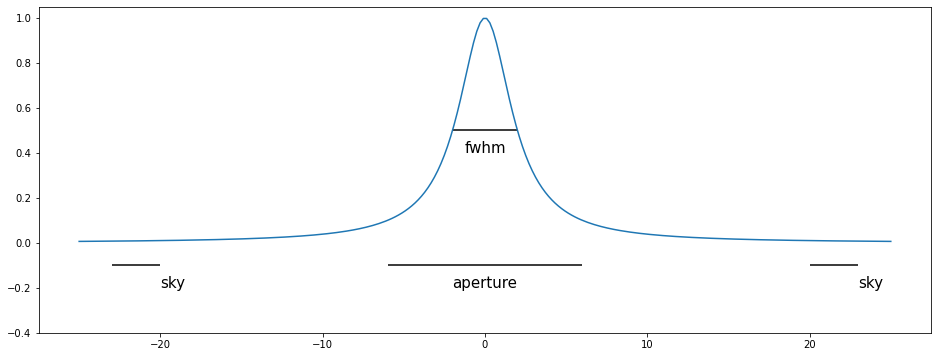

In [64]:
# Plot a 1-D model PSF
flux = 1
gamma = 2 # *Half* width at half max
alpha = 1 # power index (shape)
PSF = Moffat1D(flux, 0, gamma, alpha)

plt.figure(figsize=(16,6)) # make the plot w i d e
ymin, ymax = plt.ylim(-0.4,1.05) # make some space for labels
X = np.linspace(-25,25,250)
plt.plot(X, PSF(X))

# Label the fwhm
fwhm = PSF.fwhm
print("FWHM =", fwhm)
plt.hlines(0.5, 0-fwhm/2., 0+fwhm/2, color="k")
txt = plt.annotate("fwhm", (0, 0.4), size=15, ha="center")

# Show where a circular aperture would go
aperture_radius = 6
plt.hlines(-0.1, -aperture_radius, aperture_radius)
txt = plt.annotate("aperture", (0, -0.2), size=15, ha="center")

# Show sky annulus where background light is measured
annulus_r_in = -20
annulus_r_out = -23
plt.hlines(-0.1, -annulus_r_in, -annulus_r_out)
txt = plt.annotate("sky", (-annulus_r_out, -0.2), size=15)
plt.hlines(-0.1, annulus_r_in, annulus_r_out)
txt = plt.annotate("sky", (annulus_r_in, -0.2), size=15)

That's how everything is laid out, just imagine it rotated around the center of the star, so the sky annulus becomes a ring.

![](aperture_labelled.png)
Image Copyright © Michael Richmond. Licensed under a [Creative Commons License](http://creativecommons.org/licenses/by-nc-sa/2.0/)

### Larger apertures add more light, but also more noise

Aperture size is a trade-off between maximizing star light and minimizing noise. The three most important types of noise are:

1. Poisson noise in the star's flux
2. Poisson noise from the sky background (the aperture includes flux from the sky!)
3. CCD read noise 
- If you use a dark to remove dark current, then add in Poisson noise from the dark too.
- Honestly not sure why Poisson noise from the bias isn't included: averaging?


### Past a certain point, very little signal is added, so we'd expect that SNR would decrease. 


![](Aperture_vs_fwhm.png)

From Howell, Steve B. *Handbook of CCD Astronomy*, Cambridge University Press, 2006. 

### Understanding Noise in CCD Images

To understand noise in CCDs, you must understand how CCD counts are constructed from the photo-electrons detected. 

- Counts are sometimes called ADUs (Analog-to-Digital Units) or DNs (Data Numbers). 
- A photo-electron is an electron that has absorbed the energy of a single photon. These electrons can then be read-out.

Remember that CCDs are analog devices that use analog-to-digital converters (ADCs) to "count" the voltage produced by the read-out electronics. This converter sets the maximum number of counts, typically 65,535 since most ADCs are 16 bit devices.

### Understanding Counts

We'd like to measure photons, but we actually measure *photo-electrons*. Even then, counts are generally not equal to the number of photo-electrons detected. Instead each count is usually equal to a set number of detected photo-electrons; this number is called the *gain*.

$\text{gain} \equiv \frac{\text{# photo-electrons}}{\text{count}}$

(Some people call this inverse-gain, since the photons cause the counts, but that gets awkward. It's only defined this way to make the equations neater.)

The gain is typically set so that the maximum number of counts corresponds to the maximum number of photo-electrons each pixel can hold. The gain does affect the read noise, but because read noise is typically small, we don't often change the gain.

### Read Noise

Since read noise depends on the CCD and its electronics, it is typically measured from the standard deviation of a bias (actually you probably took the difference of a pair of biases and divided by 2). In an aperture, the contribution from read noise is,

$ \sigma_{\text{RN aperture}} = \sqrt{n_{pix} \times \sigma_{RN}^2} $

Where $n_{pix}$ is the number of pixels in your aperture, and RN is the read noise (per pixel) that you measured for your CCD.

### Poisson noise

#### From the Star

Poisson noise is just the square root of N, which in this case is the number of photo-electrons from the star (*). Because we measure counts, not photo-electrons, use gain to transform the measured total counts into the total number of photo-electrons:

$ \sigma_{*} = \sqrt{g \times N_*} $

#### From the Sky

Noise from the sky is typically expressed per pixel, so this is very similar except that you multiply by the number of pixels in your aperture:

$ \sigma_{sky} = \sqrt{n_{pix} \times g \times N_{sky}} $

Note that $n_{pix}$ is the area of the aperture, not the annulus; remember that there is sky noise **in** our aperture. The annulus is just for measuring the sky background ($N_{sky}$).

### Put all this together, and you have The CCD Equation

*The CCD Equation* is just the signal (from the star) divided by these random errors added in quadrature:

$ S/N = \frac{gN_*} {\sqrt{ gN_* + n_{pix}gN_{sky} + n_{pix}\sigma_{RN}^2 }} $

#### For Bright Sources

If $N_*$ is much greater than sky and readnoise:

$ S/N = \frac{gN_*}{\sqrt{gN_*}} = \sqrt{gN_*}$

#### A Handy Relation

It's often claimed that magnitude errors are the inverse of photometric accuracy (i.e. +/- 0.1 mags implies 10% accuracy). It's almost right. If SNR is high enough to ignore SNR^2, SNR^3, etc. terms, then:

$ \sigma_m \approx \pm 1.0875(\frac{N}{S})$

### You Can Maximize Signal to Noise

Hope for a narrow PSF so you can maximize the flux from the star and use a small aperture, which minimizes noise from the sky. Of course, we get what we get.

Consider the variable star TrES-1, located in the box in the lower right. (From Birney D.S., Gonzalez G., Oesper D. *Observational Astronomy*. 2nd ed., Cambridge University Press, 2006.)

![](Star_for_plot.jpg)

Apertures and sky anulli are shown, although TrES-1's aperture is not visible. 

### The Best S/N

The CCD Equation star has a maximum when the aperture has a radius of 6 (this star's FWHM is about 5). 
![](mag_SNR_aperture_plot.jpg)

From Birney D.S., Gonzalez G., Oesper D. *Observational Astronomy*. 2nd ed., Cambridge University Press, 2006.

### Where to put the Sky Annulus

On one hand it's tempting to measure the sky far away from the star, but in crowded fields this can be hard to do. 
- Give the star some space, but far from every other star, and not larger than your flat field failings.
- Sky annuli can easily have more area than apertures, but if you cover too much area you increase the chance of measuring very dim stars, galaxies, a cosmic ray, etc. 
- So small anulli are okay! Some of the (target) star's light will end up in the sky annulus, but it will be calibrated if you *use the same aperture to measure your standard stars.*
- Probably more important than how large it is, is how you reject data in that area. Don't average it, perhaps don't even use the median, consider the mode.


![](aperture_labelled.png)

### TLDR

- Aperature size should be 1-3 x FWHM, not more. 
- Sky annuli can be skinny; you'll still have plenty of pixels (count them!). If you average the sky pixels you're asking for trouble.
- Use the same aperture for your science stars and your standard stars
  - Or I will be sad at you. ☹️



### Aperture Photometry Forever?

Dunno, maybe. Here are other good options

- PSF Fitting: Simultaneously fit all stars in an image. An iterative process in which the bright stars are fit, then subtracted, in order to find previously hidden dim stars. Typically only for crowded fields (but things change!)
- Maximum Likelihood Analysis: Use modern statistics to estimate magnitudes. See Prof. Juric's Astro Statistics course.